<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/haripota_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ハリポタツアーの分析のデータ前処理

## データのダウンロード

一時的に作成している環境にダウンロードするだけなので、 実行しても環境は汚染されません。
最終的にデータのバランスをとった `sampled_data.pkl` というデータを作成します。このデータはテキストとラベルを列に持ちます。

In [1]:
import requests
from zipfile import ZipFile

# 1. Google Driveからファイルをダウンロードする関数
def download_from_google_drive(file_id, filename):
    download_url = f"https://drive.google.com/uc?id={file_id}"
    response = requests.get(download_url, stream=True)
    response.raise_for_status()
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

# 2. Zipファイルをダウンロード
zip_filename = "review.zip"
file_id = "1nZ2hUTAR_6RnYwTbp1mKUN0_WZwhmeRs"
download_from_google_drive(file_id, zip_filename)

# 3. Zipファイルを解凍
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("review")


In [2]:
!pip install beautifulsoup4

In [3]:
import glob
from pathlib import Path
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

PATTERN = re.compile(r'\(Translated by Google\).*')

def clean_text(text):
    """不要な部分を削除する関数"""
    return re.sub(PATTERN, '', text).strip()

def is_japanese(text):
    """テキストが日本語かどうかを判定する関数"""
    total_chars = len(text)
    if total_chars == 0:
        return False
    alphabets = len(re.findall(r'[a-zA-Z]', text))
    alpha_ratio = alphabets / total_chars
    return alpha_ratio < 0.2

def extract_japanese_texts_from_file(file_path):
    """ファイルから日本語のテキストを抽出する関数"""
    with open(file_path, 'r') as f:
        content = f.read()
        soup = BeautifulSoup(content, 'html.parser')

        texts = [span.get_text() for span in soup.find_all('span', {'class': 'review-full-text', 'style': 'display:none'})]
        japanese_texts = list(filter(is_japanese, map(clean_text, texts)))
        return japanese_texts


In [4]:
# メインの処理
# データフレームに変換
title_dict = {
    'reviews_Ghibli_Museum': 'ジブリ美術館',
    'reviews_National Museum of Nature and Science': '科学博物館',
    'reviews_National_Museum_of_Ethnology': '民族博物館',
    'reviews_The_Making_of_Harry_Potter': 'ハリポタツアー',
    'reviews_Tokyo_Disneyland': 'ディズニーランド',
    'reviews_Universal_Studios_Japan': 'USJ'
}

file_paths = glob.glob('/content/review/*.html')
file_paths

['/content/review/reviews_National Museum of Nature and Science.html',
 '/content/review/reviews_National_Museum_of_Ethnology.html',
 '/content/review/reviews_Universal_Studios_Japan.html',
 '/content/review/reviews_The_Making_of_Harry_Potter.html',
 '/content/review/reviews_Ghibli_Museum.html',
 '/content/review/reviews_Tokyo_Disneyland.html']

In [5]:
X = []
y = []

for file_path in tqdm(file_paths, desc="Processing files"):
    y_i = Path(file_path).stem
    japanese_texts = extract_japanese_texts_from_file(file_path)
    X.extend(japanese_texts)
    y.extend([title_dict[y_i]] * len(japanese_texts))

Processing files: 100%|██████████| 6/6 [00:30<00:00,  5.16s/it]


In [6]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=417fe2b5711717614018bcaf260059c03b5a0543a99e9a72b86ebc922865958a
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [7]:
import japanize_matplotlib

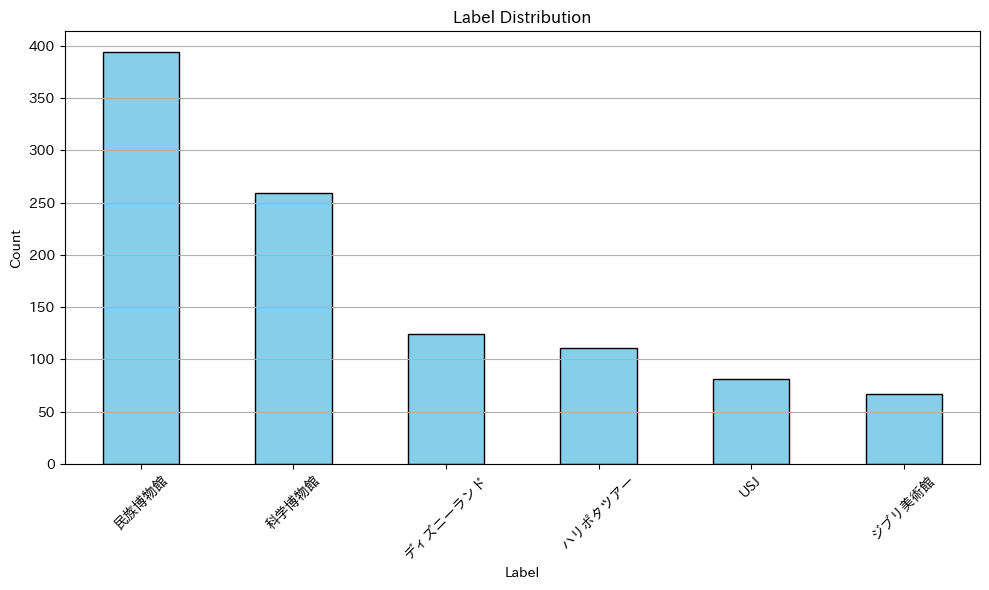

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# yのデータからDataFrameを作成
df = pd.DataFrame(y, columns=['label'])

# ヒストグラムを作成
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# グラフのタイトルとラベルを設定
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# グラフを表示
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

# DataFrameを作成
df = pd.DataFrame({
    'text': X,
    'label': y
})

# 文字数のカラムを追加
df['char_count'] = df['text'].apply(len)

# 文字数の多い順にソートして、上位N件をアンダーサンプリング
N = 64  # もっとも少なくて67件だったので、きりよく64件
under_sampled_df = df.groupby('label').apply(lambda s: s.nlargest(N, 'char_count')).reset_index(drop=True)

In [10]:
# csvだとgoogle driveにあげるとsheetになる問題
under_sampled_df.to_pickle('sampled_data.pkl')

In [11]:
# サンプリング後のデータをX, yに分ける
X_under_sampled = under_sampled_df['text'].tolist()
y_under_sampled = under_sampled_df['label'].tolist()

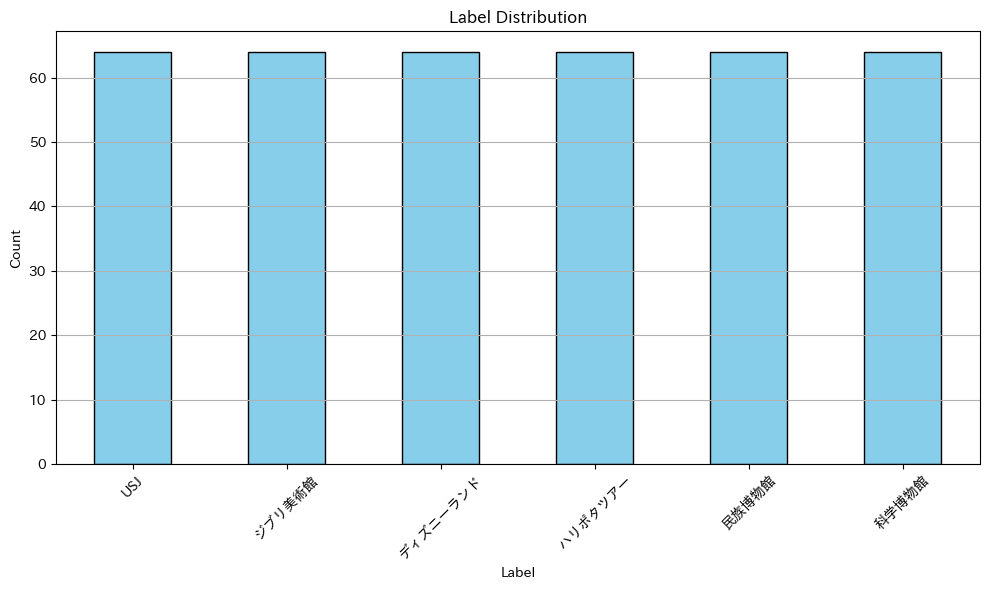

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# yのデータからDataFrameを作成
df = pd.DataFrame(y_under_sampled, columns=['label'])

# ヒストグラムを作成
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# グラフのタイトルとラベルを設定
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# グラフを表示
plt.tight_layout()
plt.show()


In [13]:
under_sampled_df.head()

,text,label,char_count
0,子供の春休みに全国旅行支援で神戸の枠が空いていたので、USJを中心として兵庫県と大阪府にお邪...,USJ,972
1,ユニバーサルスタジオジャパン（USJ）は、大阪に位置する世界的に有名なテーマパークです。US...,USJ,791
2,初めて行きました。個人的にはディ○ニーよUSJの方がスタッフさんがアドリブが効くと言うかアッ...,USJ,714
3,5月末ころ行きました！子供産んでから初ユニバ！子供がマリオ大好きなのでなんとかマリオエリアに...,USJ,669
4,マリオワールドがすごい！ゲームの中にいるみたい🌟ただニンテンドーワールドはエリア入場整理券が...,USJ,572
